# Расчет газожидкостной смеси через штуцер:
### 1. Расчет расхода в зависимости от давления на выходе, при разных давлениях на входе
### 2. Расчет давления на входе в зависимости от расхода, при разных давлениях на выходе
### 3. Расчет давления на выходе в зависимости от расхода, при разных давлениях на входе

Расчеты ведутся на основе методики T.K. Perkins, Arco E&P Technology

статья SPE: Critical  and  Subcritical  Flow  of Multiphase  Mixtures  Through  Chokes

https://www.onepetro.org/journal-paper/SPE-20633

Модель позволяет считать и учитывать температуру и давление в штуцере. Расчитывать границу перехода с критического на докритически режим.

Проводились испытания с потоками воздух/вода, воздух/керосин, природный газ, природный газ/нефть, природный газ/вода, вода.  Испытания дали среднюю погрешность с стандартным отклонением 15,4%.

В статье не рассматриваются системы связанные с конденсацией газовой фазы, (например насыщенный пар).

Не рассматривались условия, которые приводят давление в штуцере меньше, чем давление паров в водной фазе. 

Поток смеси является изоэнтропическим (адиабатический и без потерь на трение).

Рассчитывается теоретический расход, для нахождения фактического необходимо домножить а коэффициент a=0.78-0.9, который является эмпирическим.

Модель адаптирована для насыщенного пара, можно также использовать и для трехфазной смеси (нефть+газ+вода).

In [102]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sympy import *
import scipy.optimize as opt
import logging
from pyXSteam.XSteam import XSteam
steamTable = XSteam(XSteam.UNIT_SYSTEM_MKS)

In [103]:
def wi_kghr(p1_atm,p2_atm, T_C=20, d2_mm=5):
   
    """
    расчет расхода ГЖС через штуцер по методике Перкинса
    p1_atm - давление на входе в штуцер, атм
    p2_atm - давление на выходе из штуцера, атм
    T_C - температура, С
    d0_mm - диаметр штуцера, мм
    """
    fg=1 # весовая доля газа в потоке или по другому сухость пара
    fo=0 # весовая доля нефти в потоке
    fw=0 # весовая доля воды в потоке
    M_m=18 # молекулярный вес, моль пара
    z=0.999 # коэффициент сжимаемости газа
    rog_kgm3=steamTable.rhoV_p(p1_atm) # плотность пара кг/м3
    row_kgm3=steamTable.rhoL_p(p1_atm) # плотность воды   кг/м3
    Cvw=0.24*778.169*steamTable.CvL_p(p1_atm)  # удельная теплоемкость жидкости 1 кДж/кгК= 1*0,24*778.169=(ft-Ibf)/(lbm- OF)
    Cvg=0.24*778.169*steamTable.CvV_p(p1_atm)  # удельная теплоемкость пара при постоянном объеме, кДж/кг/К 
    Cpg=0.24*778.169*steamTable.CpV_p(p1_atm)  # удельная теплоемкость пара при постоянном давлении, кДж/кг/К
    d1_mm=100 #диаметр трубы до штуцера мм
    g_c=32.17 #(lbm-ft)/(lbf-second^2)
    roo_kgm3=800 # плотность нефти   кг/м3 ( в данном случае не учитывается)
    roo=roo_kgm3*0.062428 # плотность нефти  Ibm/ft3
    row=row_kgm3*0.062428 # плотность воды  Ibm/ft3
    gamma_o=141.5/roo_kgm3/1000-131.5 #плотность нефти, API
    T_F=T_C*1.8 + 32 # температура, F
    R_ftIbtlbmmolR=1545.348 # универсальная газовая постоянная  (ft-Ibf)/(lbm mol-R)
    Cvo=778*((0.355+0.00176*gamma_o)+(0.0051+1.167*gamma_o/100000)*T_F) #  теплоемкость при постоянном объеме для нефти (ft-Ibf)/(lbm- OF) 
    F=Cpg/Cvg # показатель адиабаты
    p1_psia=p1_atm*14.2233 # давление перед штуцером в psia
    p2_psia=p2_atm*14.2233 # давление за штуцером в psia
    d1_ft=d1_mm/304.8 # диаметр трубы в ft
    d2_ft=d2_mm/304.8 # диаметр штуцера в ft
    v1_ft3lbm=16.01845/rog_kgm3 # удельный объем газа ft3/Ibm
    alf=(1/v1_ft3lbm)*(fo/roo+fw/row)
    A1_ft2=3.14*d1_ft**2/4
    A2_ft2=3.14*d2_ft**2/4
    n=(fg*F*Cvg+fo*Cvo+fw*Cvw)/(fg*Cvg+fo*Cvo+fw*Cvw)
    lambd=fg+((fg*Cvg+fo*Cvo+fw*Cvw)*M_m/(z*R_ftIbtlbmmolR))
    i=0
    pr1=0.1
    pr11=0.2
    """
    Пересчитываю отношение давлений столько раз, пока разница между следующим и предыдущим не будет очень маленькой.
    Отношение давлений служит для того, чтобы найти давление в штуцере.
    """
    while abs(pr1-pr11)>0.001 and i<10: # пересчитываем удельные теплоемкости и давление в штуцере, пока они не будут соответствовать A*(B+C)=D*E
        def qw(pr2):
            A=2*lambd*(1-pr2**((n-1)/n))+2*alf*(1-pr2)
            B=(1-((A2_ft2/A1_ft2)**2)*((fg+alf)/((fg*pr2**(-1/n))+alf))**2)*(fg/n*pr2**(-(1+n)/n))
            C=(A2_ft2/A1_ft2)**2*fg/n*(fg+alf)**2*pr2**(-(1+n)/n)/((fg*pr2**(-1/n))+alf)**2
            D=(1-(A2_ft2/A1_ft2)*((fg+alf)/((fg*pr2**(-1/n))+alf))**2)*((fg*pr2**(-1/n))+alf)
            E=lambd*(n-1)/n*pr2**(-1/n)+alf
            return A*(B+C)-D*E
        pr1=opt.fsolve(qw,0.01) #находим отношение давления в штуцере и давления перед штуцером
        p3_psia=p1_psia*pr1 #находим давление в штуцере
        pmid_atm=(p1_psia+p3_psia)/2/14.2233 # среднее давление в штуцере и перед штуцером, пересчитываем удельные теплоемкости для этого давления
        Cvw=0.24*778.169*steamTable.CvL_p(pmid_atm)  # удельная теплоемкость жидкости 1 кДж/кгК= 1*0,24*778.169=(ft-Ibf)/(lbm- OF)
        Cvg=0.24*778.169*steamTable.CvV_p(pmid_atm)  # удельная теплоемкость пара при постоянном объеме, кДж/кг/К 
        Cpg=0.24*778.169*steamTable.CpV_p(pmid_atm)  # удельная теплоемкость пара при постоянном давлении, кДж/кг/К
        F=Cpg/Cvg
        n=(fg*F*Cvg+fo*Cvo+fw*Cvw)/(fg*Cvg+fo*Cvo+fw*Cvw)
        lambd=fg+((fg*Cvg+fo*Cvo+fw*Cvw)*M_m/(z*R_ftIbtlbmmolR))
        pr11=opt.fsolve(qw,0.01)
        i=i+1
    if p3_psia>p2_psia:pr= p3_psia/p1_psia
    else: pr=p2_psia/p1_psia
    if pr>1: pr=1
    Ab=(lambd*(1-pr**((n-1)/n))+alf*(1-pr))/((1-((A2_ft2/A1_ft2)**2)*((fg+alf)/((fg*pr**(-1/n))+alf))**2)*((fg*pr**(-1/n))+alf)**2)
    wi_lbmsec=A2_ft2*((288*g_c*p1_psia/v1_ft3lbm)*Ab)**0.5
    wi_kghr=wi_lbmsec*0.45359*3600 # перевод в кг/час
    T2_F=(T_F+460)*pr1**((n-1)/n)-460 #Температура в штуцере в F
    T2_C=(T2_F-32)/1.8 #Температура в штуцере в С
    return wi_kghr

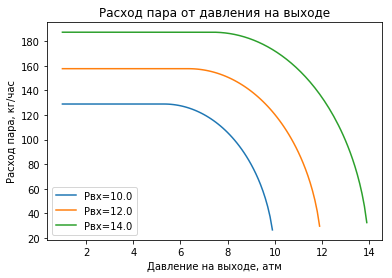

In [104]:
'Построение графика "Расход пара от давления на выходе"'
p1_atm_a= np.arange(10,16,2) #давление на входе для которых расчитывается расход, в зависимости от давления на выходе, атм
for p1_atm in p1_atm_a:
    p2_a=np.arange(1,p1_atm,0.1)
    q=np.array([])
    for p2 in p2_a:
        p1=wi_kghr(p1_atm, p2,5)
        q=np.append(q,p1)
    plt.plot(p2_a,q,label='Рвх=%1.1f'%p1_atm) 
plt.title('Расход пара от давления на выходе')
plt.ylabel('Расход пара, кг/час')
plt.xlabel('Давление на выходе, атм')
plt.legend()
plt.show()

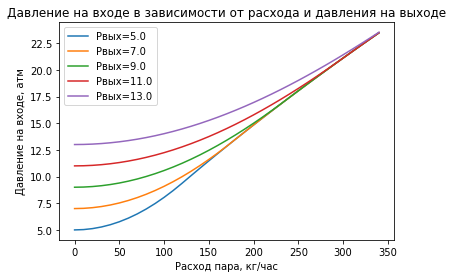

In [105]:
'Построение графика "Давление на входе в зависимости от расхода и давления на выходе"'
'Давление на входе считается с помощью функции opt.fsolve '
p2_atm_a= np.arange(5,15,2)  #давление на выходе для которых расчитываются давления на входе в зависимости от расхода, атм
for p2_atm in p2_atm_a:
    i_a=np.arange(0,350,10) # расход, кг/час для которого находится давление на входе
    for i in i_a:
        def w2(p1_atm):
            return wi_kghr(p1_atm,p2_atm)-i
        def p1_atm(w2):
            p1_atm=opt.fsolve(w2,p2_atm)
            return p1_atm
    q=np.array([])
    for i in i_a:
        p1=p1_atm(w2)
        q=np.append(q,p1)
    plt.plot(i_a,q,label='Рвых=%1.1f'%p2_atm)
plt.title('Давление на входе в зависимости от расхода и давления на выходе')
plt.xlabel('Расход пара, кг/час')
plt.ylabel('Давление на входе, атм')   
plt.legend()
plt.show() 

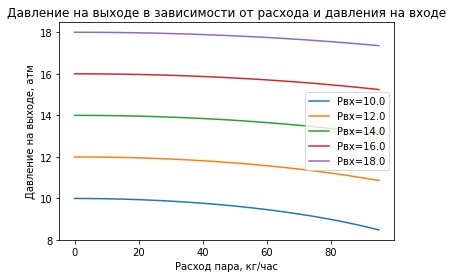

In [106]:
'Построение графика "Давление на выходе в зависимости от расхода и давления на входе"'
'Давление на выходе считается с помощью функции opt.fsolve '
p1_atm_a= np.arange(10,20,2)  #давление на входе для которых расчитываются давления на выходе в зависимости от расхода, атм
for p1_atm in p1_atm_a:
    i_a=np.arange(0,100,5) # расход, кг/час для которого находится давление на выходе
    for i in i_a:
        def w2(p2_atm):
            return wi_kghr(p1_atm,p2_atm)-i
        def p2_atm(w2):
            p2_atm=opt.fsolve(w2,p1_atm-0.00001)
            return p2_atm
    q=np.array([])
    for i in i_a:
        p2=p2_atm(w2)
        q=np.append(q,p2)
    plt.plot(i_a,q,label='Рвх=%1.1f'%p1_atm)
plt.title('Давление на выходе в зависимости от расхода и давления на входе')
plt.xlabel('Расход пара, кг/час')
plt.ylabel('Давление на выходе, атм')   
plt.legend()
plt.show()  

# Расчет потока газожидкостной смеси через штуцер
### Формула для расчета изоэнтропического массового расхода смеси
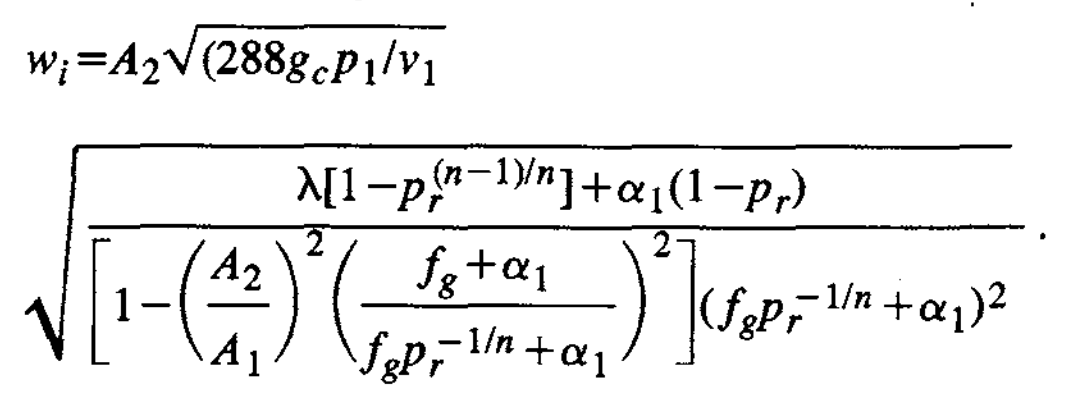
### где
$fg$ - весовая доля газа в потоке

$fo$ - весовая доля нефти в потоке

$fw$ - весовая доля воды в потоке

$M_m$ - молекулярный вес

$z$ - коэффициент сжимаемости газа

$F$ - показатель адиабаты $c_p/c_v$

$\rho_g$ - плотность пара

$\rho_o$ - плотность нефти

$\rho_w$ - плотность воды

$v_1$ -  удельный объем

$T$ - температура

$R$ - универсальная газовая постоянная

$p_1$ - давление перед штуцером

$p_2$ - давление в штуцере

$p_4$ - давление в трубе далеко за штуцером

$p_3$ - давление в трубе сразу за штуцером

$d_1$ - диаметр трубы до штуцера

$d_2$ - диаметр штуцера

$A_1$ - площадь трубы $A_1=\frac{\pi*d_1^2}{4}$

$A_2$ - площадь штуцера $A_2=\frac{\pi*d_2^2}{4}$

$C_{vg}$ - теплоемкость при постоянном объеме для газа

$C_{vo}$ - теплоемкость при постоянном объеме для нефти 

$C_{vw}$ - теплоемкость при постоянном объеме для воды 

### $n=\frac{f_g*F*C_{vg}+f_o*C_{vo}+f_w*C_{vw}}{f_g*C_{vg}+f_o*C_{vo}+f_w*C_{vw}}$

### $\lambda=f_g+\frac{(f_g*C_{vg}+f_o*C_{vo}+f_w*C_{vw})*M_m}{z*R}$

### $\alpha_1 = \frac{1}{v_1}*(\frac{f_o}{\rho_o}+\frac{f_w}{\rho_w})$

### $p_3=p_1-\frac{p_1-p_4}{1-(\frac{d_2}{d_1})^{1.85}}$ 

### $ p_r=\frac{p_2}{p_1}$  при  $p_2 > p_3 $ и

### $ p_r=\frac{p_3}{p_1}$  при  $p_3 > p_2 $ 




## Расчетный массовый расход вычисляется по формуле:
### $w_c=w_i*K$

$ K=\frac{w_a}{w_i} $

$w_a$ - фактический массовый расход